# Tennis Match Feature Engineering and Upset Analysis

This notebook builds upon our previous data cleaning and exploratory analysis to investigate what features influence tennis match upsets. We'll create and analyze various derived features that capture different aspects of player performance and match dynamics.

## Feature Categories

1. **Serve Aggressiveness**
   - Ace to double fault ratio
   - Service point win percentages
   - First serve effectiveness

2. **Recent Form**
   - 3-month rolling win-loss ratio
   - 6-month rolling win-loss ratio
   - 12-month rolling win-loss ratio

3. **Surface Specialization**
   - Surface-specific win rates
   - Performance differentials across surfaces
   - Surface adaptation indicators

4. **Head-to-Head Dynamics**
   - Historical matchup statistics
   - Win percentages against specific opponents
   - Performance in previous meetings

5. **Psychological Momentum**
   - Break point conversion rates
   - Set momentum indicators
   - Winning streak metrics

We'll create these features and analyze their relationship with match upsets using statistical methods and visualization techniques.

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
sns.set_theme(style="whitegrid")  # Use seaborn's whitegrid style
sns.set_palette("husl")
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

In [6]:
# Load the clean dataset
years = [2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
all_matches = pd.concat([pd.read_csv(f'c:/poly_code/Atp_Matches_Folder/atp_matches_{year}.csv') for year in years], ignore_index=True)

# Apply the same cleaning steps from data_cleaning.ipynb
clean_matches = all_matches[
    (~all_matches['score'].str.contains('RET', na=False)) & 
    (all_matches['minutes'] >= 30)
].copy()

# Create upset variable from exp_data_analysis.ipynb
clean_matches['rank_difference'] = clean_matches['winner_rank'] - clean_matches['loser_rank']
clean_matches['upset'] = ((clean_matches['rank_difference'] > 0) & 
                         (abs(clean_matches['rank_difference']) >= 20)).astype(int)

# Convert tournament date to datetime
clean_matches['tourney_date'] = pd.to_datetime(clean_matches['tourney_date'].astype(str), format='%Y%m%d')

# Display basic information about the dataset
print("Dataset Overview:")
print(f"Number of matches: {len(clean_matches)}")
print(f"Date range: {clean_matches['tourney_date'].min()} to {clean_matches['tourney_date'].max()}")
print(f"Number of upsets: {clean_matches['upset'].sum()}")
print(f"Upset percentage: {(clean_matches['upset'].mean() * 100):.2f}%")

Dataset Overview:
Number of matches: 21517
Date range: 2016-01-04 00:00:00 to 2024-12-18 00:00:00
Number of upsets: 5181
Upset percentage: 24.08%


## 1. Serve Aggressiveness Features

Let's start by creating features related to serving performance and aggressiveness. These features will capture:
1. Ace to double fault ratio
2. First serve effectiveness
3. Service points won percentage
4. Break points saved ratio

In [7]:
# Create serve aggressiveness features

def calculate_serve_features(df):
    # Create a copy of the dataframe
    df = df.copy()
    
    # 1. Ace to double fault ratio (handle division by zero)
    df['w_ace_df_ratio'] = df['w_ace'] / df['w_df'].replace(0, 1)
    df['l_ace_df_ratio'] = df['l_ace'] / df['l_df'].replace(0, 1)
    
    # 2. First serve effectiveness (percentage of first serves in)
    df['w_1st_serve_pct'] = df['w_1stIn'] / df['w_svpt']
    df['l_1st_serve_pct'] = df['l_1stIn'] / df['l_svpt']
    
    # 3. First serve points won percentage
    df['w_1st_serve_won_pct'] = df['w_1stWon'] / df['w_1stIn']
    df['l_1st_serve_won_pct'] = df['l_1stWon'] / df['l_1stIn']
    
    # 4. Second serve points won percentage
    df['w_2nd_serve_won_pct'] = df['w_2ndWon'] / (df['w_svpt'] - df['w_1stIn'])
    df['l_2nd_serve_won_pct'] = df['l_2ndWon'] / (df['l_svpt'] - df['l_1stIn'])
    
    # 5. Break points saved percentage
    df['w_bp_saved_pct'] = df['w_bpSaved'] / df['w_bpFaced'].replace(0, 1)
    df['l_bp_saved_pct'] = df['l_bpSaved'] / df['l_bpFaced'].replace(0, 1)
    
    # 6. Overall serve efficiency (composite metric)
    df['w_serve_efficiency'] = (df['w_ace_df_ratio'] * df['w_1st_serve_won_pct'] * 
                               df['w_2nd_serve_won_pct'] * df['w_bp_saved_pct'])
    df['l_serve_efficiency'] = (df['l_ace_df_ratio'] * df['l_1st_serve_won_pct'] * 
                               df['l_2nd_serve_won_pct'] * df['l_bp_saved_pct'])
    
    # Replace infinities and clean up NaNs
    serve_cols = [col for col in df.columns if col.endswith(('ratio', 'pct', 'efficiency'))]
    df[serve_cols] = df[serve_cols].replace([np.inf, -np.inf], np.nan)
    df[serve_cols] = df[serve_cols].fillna(df[serve_cols].mean())
    
    return df

# Calculate serve features
clean_matches = calculate_serve_features(clean_matches)

# Display summary statistics of new serve features
serve_features = [col for col in clean_matches.columns if col.endswith(('ratio', 'pct', 'efficiency'))]
print("Serve Features Summary Statistics:")
display(clean_matches[serve_features].describe().round(3))

Serve Features Summary Statistics:


,w_ace_df_ratio,l_ace_df_ratio,w_1st_serve_pct,l_1st_serve_pct,w_1st_serve_won_pct,l_1st_serve_won_pct,w_2nd_serve_won_pct,l_2nd_serve_won_pct,w_bp_saved_pct,l_bp_saved_pct,w_serve_efficiency,l_serve_efficiency
count,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000
mean,3.754,2.293,0.627,0.609,0.769,0.668,0.566,0.458,0.603,0.515,1.000,0.423
std,3.785,2.705,0.075,0.076,0.079,0.091,0.104,0.101,0.326,0.202,1.488,0.723
min,0.000,0.000,0.349,0.298,0.467,0.206,0.118,0.000,0.000,0.000,0.000,0.000
25%,1.250,0.667,0.577,0.559,0.714,0.610,0.500,0.394,0.500,0.400,0.126,0.067
50%,2.500,1.500,0.627,0.610,0.769,0.672,0.560,0.462,0.667,0.545,0.498,0.200
75%,5.000,3.000,0.677,0.660,0.824,0.730,0.630,0.524,0.833,0.667,1.260,0.484
max,49.000,44.000,0.969,0.943,1.000,0.971,1.000,0.889,1.000,1.000,29.621,25.776


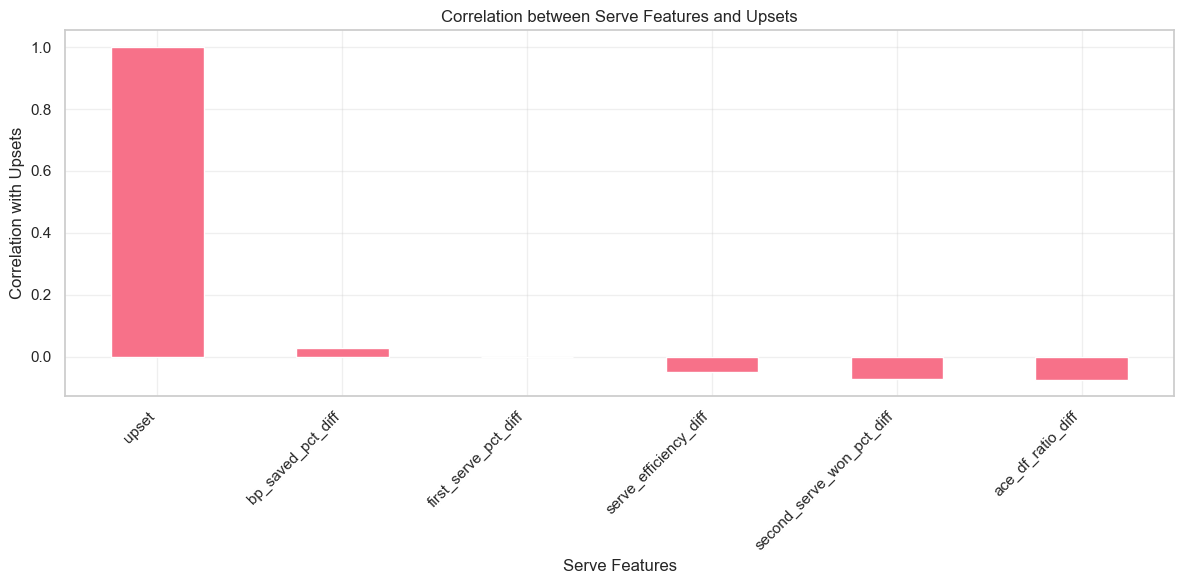


Correlation with Upsets:
upset                        1.000
bp_saved_pct_diff            0.029
first_serve_pct_diff         0.001
serve_efficiency_diff       -0.049
second_serve_won_pct_diff   -0.070
ace_df_ratio_diff           -0.073
Name: upset, dtype: float64


In [8]:
# Analyze the relationship between serve features and upsets

# Calculate serve feature differences between winner and loser
serve_diffs = pd.DataFrame()
serve_diffs['ace_df_ratio_diff'] = clean_matches['w_ace_df_ratio'] - clean_matches['l_ace_df_ratio']
serve_diffs['first_serve_pct_diff'] = clean_matches['w_1st_serve_pct'] - clean_matches['l_1st_serve_pct']
serve_diffs['first_serve_won_pct_diff'] = clean_matches['w_1st_serve_won_pct'] - clean_matches['l_1st_serve_won_pct']
serve_diffs['second_serve_won_pct_diff'] = clean_matches['w_2nd_serve_won_pct'] - clean_matches['l_2nd_serve_won_pct']
serve_diffs['bp_saved_pct_diff'] = clean_matches['w_bp_saved_pct'] - clean_matches['l_bp_saved_pct']
serve_diffs['serve_efficiency_diff'] = clean_matches['w_serve_efficiency'] - clean_matches['l_serve_efficiency']

# Add upset column
serve_diffs['upset'] = clean_matches['upset']

# Create correlation matrix
correlation_matrix = serve_diffs.corr()['upset'].sort_values(ascending=False)

# Visualize correlations
plt.figure(figsize=(12, 6))
correlation_matrix[:-1].plot(kind='bar')
plt.title('Correlation between Serve Features and Upsets')
plt.xlabel('Serve Features')
plt.ylabel('Correlation with Upsets')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCorrelation with Upsets:")
print(correlation_matrix[:-1].round(3))

## 2. Recent Form Features

Now let's create features that capture players' recent performance. We'll calculate:
1. Rolling win-loss ratios for 3, 6, and 12-month windows
2. Recent tournament performance
3. Streak indicators

In [9]:
# Calculate recent form features

def calculate_player_form(df, player_name, date, window_months):
    # Get matches before the current date for the player
    mask = (df['tourney_date'] < date) & (
        (df['winner_name'] == player_name) | (df['loser_name'] == player_name)
    )
    player_matches = df[mask]
    
    # Calculate wins and total matches in the window
    window_start = date - pd.Timedelta(days=30.44 * window_months)  # Approximate month length
    recent_matches = player_matches[player_matches['tourney_date'] >= window_start]
    
    if len(recent_matches) == 0:
        return 0.5  # Default value for players with no recent matches
    
    wins = len(recent_matches[recent_matches['winner_name'] == player_name])
    total_matches = len(recent_matches)
    
    return wins / total_matches if total_matches > 0 else 0.5

def calculate_form_features(df):
    df = df.copy()
    windows = [3, 6, 12]  # Months
    
    for window in windows:
        print(f"Calculating {window}-month form...")
        
        # Calculate form for winners
        df[f'w_form_{window}m'] = df.apply(
            lambda row: calculate_player_form(df, row['winner_name'], 
                                           row['tourney_date'], window), axis=1
        )
        
        # Calculate form for losers
        df[f'l_form_{window}m'] = df.apply(
            lambda row: calculate_player_form(df, row['loser_name'], 
                                           row['tourney_date'], window), axis=1
        )
    
    return df

# Calculate form features
clean_matches = calculate_form_features(clean_matches)

# Display summary of form features
form_features = [col for col in clean_matches.columns if 'form' in col]
print("\nRecent Form Features Summary:")
display(clean_matches[form_features].describe().round(3))

Calculating 3-month form...
Calculating 6-month form...
Calculating 12-month form...

Recent Form Features Summary:


,w_form_3m,l_form_3m,w_form_6m,l_form_6m,w_form_12m,l_form_12m
count,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000
mean,0.513,0.450,0.525,0.463,0.530,0.469
std,0.214,0.209,0.190,0.187,0.175,0.171
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.400,0.333,0.429,0.375,0.444,0.400
50%,0.500,0.500,0.524,0.500,0.524,0.500
75%,0.667,0.571,0.643,0.571,0.638,0.562
max,1.000,1.000,1.000,1.000,1.000,1.000


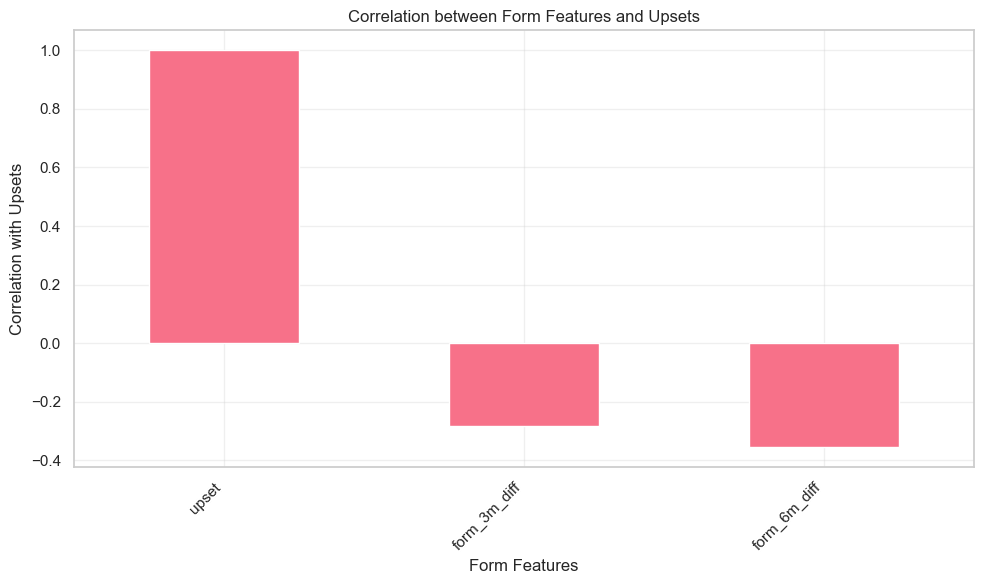


Correlation with Upsets:
upset           1.000
form_3m_diff   -0.284
form_6m_diff   -0.355
Name: upset, dtype: float64

Average Form Differences:

In Upset Matches:


form_3m_diff    -0.079
form_6m_diff    -0.094
form_12m_diff   -0.108
dtype: float64


In Non-Upset Matches:


form_3m_diff     0.108
form_6m_diff     0.112
form_12m_diff    0.114
dtype: float64

In [10]:
# Analyze relationship between form features and upsets

# Calculate form differences
form_diffs = pd.DataFrame()
for window in [3, 6, 12]:
    form_diffs[f'form_{window}m_diff'] = (
        clean_matches[f'w_form_{window}m'] - clean_matches[f'l_form_{window}m']
    )

form_diffs['upset'] = clean_matches['upset']

# Calculate correlations
form_correlations = form_diffs.corr()['upset'].sort_values(ascending=False)

# Visualize correlations
plt.figure(figsize=(10, 6))
form_correlations[:-1].plot(kind='bar')
plt.title('Correlation between Form Features and Upsets')
plt.xlabel('Form Features')
plt.ylabel('Correlation with Upsets')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCorrelation with Upsets:")
print(form_correlations[:-1].round(3))

# Additional analysis: Average form differences in upset vs non-upset matches
print("\nAverage Form Differences:")
print("\nIn Upset Matches:")
display(form_diffs[form_diffs['upset'] == 1][form_diffs.columns[:-1]].mean().round(3))
print("\nIn Non-Upset Matches:")
display(form_diffs[form_diffs['upset'] == 0][form_diffs.columns[:-1]].mean().round(3))

## 3. Surface Specialization Features

Now we'll create features that capture players' performance on different surfaces:
1. Surface-specific win rates
2. Historical performance on each surface
3. Surface adaptation indicators (performance change across surfaces)

In [11]:
# Calculate surface specialization features

def calculate_surface_stats(df, player_name, surface, date):
    # Get matches before the current date for the player on the specific surface
    mask = (
        (df['tourney_date'] < date) &
        (df['surface'] == surface) &
        ((df['winner_name'] == player_name) | (df['loser_name'] == player_name))
    )
    player_matches = df[mask]
    
    if len(player_matches) == 0:
        return 0.5  # Default value for players with no matches on this surface
    
    # Calculate win rate
    wins = len(player_matches[player_matches['winner_name'] == player_name])
    total_matches = len(player_matches)
    
    return wins / total_matches

def calculate_surface_features(df):
    df = df.copy()
    surfaces = df['surface'].unique()
    
    for surface in surfaces:
        print(f"Calculating {surface} surface stats...")
        
        # Calculate surface-specific win rates for winners
        df[f'w_{surface.lower()}_winrate'] = df.apply(
            lambda row: calculate_surface_stats(df, row['winner_name'], 
                                             surface, row['tourney_date']), axis=1
        )
        
        # Calculate surface-specific win rates for losers
        df[f'l_{surface.lower()}_winrate'] = df.apply(
            lambda row: calculate_surface_stats(df, row['loser_name'], 
                                             surface, row['tourney_date']), axis=1
        )
    
    # Calculate surface adaptation (difference between current surface and others)
    df['current_surface'] = df['surface']
    for surface in surfaces:
        mask = df['current_surface'] == surface
        other_surfaces = [s for s in surfaces if s != surface]
        
        # Calculate average win rate on other surfaces
        for player_type in ['w', 'l']:
            other_surface_cols = [f'{player_type}_{s.lower()}_winrate' for s in other_surfaces]
            current_surface_col = f'{player_type}_{surface.lower()}_winrate'
            
            df.loc[mask, f'{player_type}_surface_adaptation'] = (
                df.loc[mask, current_surface_col] - 
                df.loc[mask, other_surface_cols].mean(axis=1)
            )
    
    return df

# Calculate surface features
clean_matches = calculate_surface_features(clean_matches)

# Display summary of surface features
surface_features = [col for col in clean_matches.columns if any(surface.lower() in col 
                   for surface in clean_matches['surface'].unique())]
surface_features.extend(['w_surface_adaptation', 'l_surface_adaptation'])

print("\nSurface Specialization Features Summary:")
display(clean_matches[surface_features].describe().round(3))

Calculating Hard surface stats...
Calculating Clay surface stats...
Calculating Carpet surface stats...
Calculating Grass surface stats...

Surface Specialization Features Summary:


,w_hard_winrate,l_hard_winrate,w_clay_winrate,l_clay_winrate,w_carpet_winrate,l_carpet_winrate,w_grass_winrate,l_grass_winrate,w_surface_adaptation,l_surface_adaptation
count,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000
mean,0.510,0.452,0.503,0.459,0.499,0.499,0.471,0.428,0.031,-0.001
std,0.178,0.173,0.183,0.179,0.040,0.042,0.223,0.212,0.165,0.178
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.711,-0.711
25%,0.421,0.379,0.429,0.385,0.500,0.500,0.368,0.333,-0.029,-0.068
50%,0.503,0.478,0.500,0.500,0.500,0.500,0.500,0.500,0.042,0.014
75%,0.622,0.551,0.607,0.564,0.500,0.500,0.615,0.556,0.129,0.103
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.833,0.833


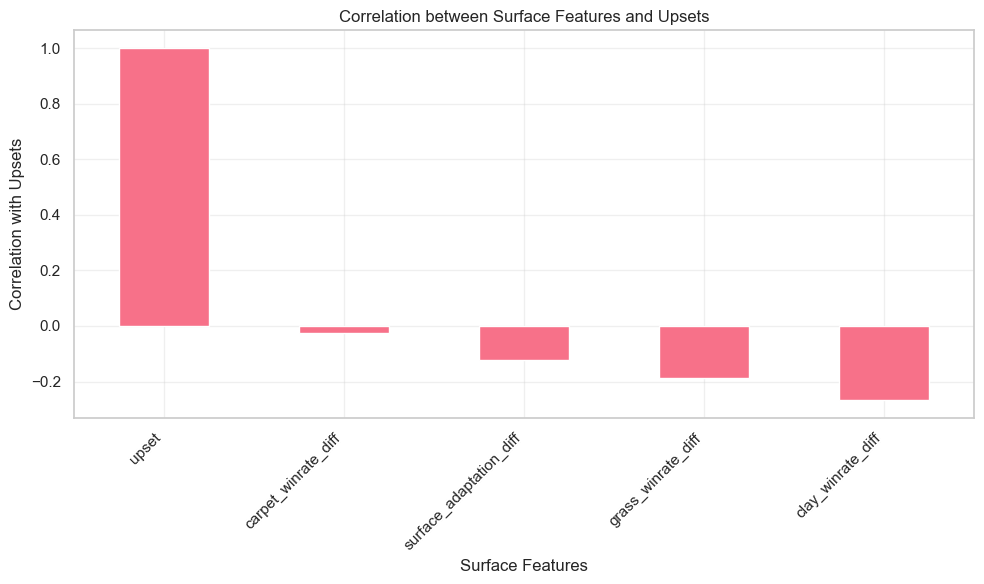


Correlation with Upsets:
upset                      1.000
carpet_winrate_diff       -0.024
surface_adaptation_diff   -0.123
grass_winrate_diff        -0.188
clay_winrate_diff         -0.267
Name: upset, dtype: float64

Mean Feature Differences by Surface Type:

Hard Courts:

In Upset Matches:


hard_winrate_diff         -0.073
clay_winrate_diff         -0.076
carpet_winrate_diff       -0.003
grass_winrate_diff        -0.066
surface_adaptation_diff   -0.025
upset                      1.000
dtype: float64


In Non-Upset Matches:


hard_winrate_diff          0.104
clay_winrate_diff          0.075
carpet_winrate_diff        0.001
grass_winrate_diff         0.081
surface_adaptation_diff    0.052
upset                      0.000
dtype: float64


Clay Courts:

In Upset Matches:


hard_winrate_diff         -0.080
clay_winrate_diff         -0.069
carpet_winrate_diff       -0.001
grass_winrate_diff        -0.053
surface_adaptation_diff   -0.025
upset                      1.000
dtype: float64


In Non-Upset Matches:


hard_winrate_diff          0.084
clay_winrate_diff          0.091
carpet_winrate_diff        0.000
grass_winrate_diff         0.048
surface_adaptation_diff    0.047
upset                      0.000
dtype: float64


Carpet Courts:

In Upset Matches:


hard_winrate_diff          0.119
clay_winrate_diff          0.000
carpet_winrate_diff       -0.167
grass_winrate_diff         0.000
surface_adaptation_diff   -0.206
upset                      1.000
dtype: float64


In Non-Upset Matches:


hard_winrate_diff          0.036
clay_winrate_diff          0.060
carpet_winrate_diff       -0.012
grass_winrate_diff         0.000
surface_adaptation_diff   -0.044
upset                      0.000
dtype: float64


Grass Courts:

In Upset Matches:


hard_winrate_diff         -0.058
clay_winrate_diff         -0.075
carpet_winrate_diff       -0.006
grass_winrate_diff        -0.031
surface_adaptation_diff    0.015
upset                      1.000
dtype: float64


In Non-Upset Matches:


hard_winrate_diff          0.111
clay_winrate_diff          0.088
carpet_winrate_diff        0.001
grass_winrate_diff         0.102
surface_adaptation_diff    0.035
upset                      0.000
dtype: float64

In [12]:
# Analyze relationship between surface features and upsets

# Calculate surface feature differences
surface_diffs = pd.DataFrame()

# Add win rate differences for each surface
for surface in clean_matches['surface'].unique():
    surface_diffs[f'{surface.lower()}_winrate_diff'] = (
        clean_matches[f'w_{surface.lower()}_winrate'] - 
        clean_matches[f'l_{surface.lower()}_winrate']
    )

# Add surface adaptation difference
surface_diffs['surface_adaptation_diff'] = (
    clean_matches['w_surface_adaptation'] - 
    clean_matches['l_surface_adaptation']
)

surface_diffs['upset'] = clean_matches['upset']

# Calculate correlations
surface_correlations = surface_diffs.corr()['upset'].sort_values(ascending=False)

# Visualize correlations
plt.figure(figsize=(10, 6))
surface_correlations[:-1].plot(kind='bar')
plt.title('Correlation between Surface Features and Upsets')
plt.xlabel('Surface Features')
plt.ylabel('Correlation with Upsets')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCorrelation with Upsets:")
print(surface_correlations[:-1].round(3))

# Analysis by surface type
print("\nMean Feature Differences by Surface Type:")
for surface in clean_matches['surface'].unique():
    print(f"\n{surface} Courts:")
    surface_matches = surface_diffs[clean_matches['surface'] == surface]
    
    print("\nIn Upset Matches:")
    display(surface_matches[surface_matches['upset'] == 1].mean().round(3))
    print("\nIn Non-Upset Matches:")
    display(surface_matches[surface_matches['upset'] == 0].mean().round(3))

## 4. Head-to-Head Features

Let's create features that capture the historical matchup statistics between players:
1. Historical head-to-head record
2. Win percentage in previous meetings
3. Surface-specific head-to-head performance

In [13]:
# Calculate head-to-head features

def calculate_h2h_stats(df, player1, player2, date, surface=None):
    # Get previous matches between these players
    mask = (
        (df['tourney_date'] < date) &
        (
            ((df['winner_name'] == player1) & (df['loser_name'] == player2)) |
            ((df['winner_name'] == player2) & (df['loser_name'] == player1))
        )
    )
    
    if surface:
        mask &= (df['surface'] == surface)
    
    previous_matches = df[mask]
    
    if len(previous_matches) == 0:
        return 0.5  # Default value for no previous meetings
    
    # Calculate head-to-head win rate for player1
    player1_wins = len(previous_matches[previous_matches['winner_name'] == player1])
    total_matches = len(previous_matches)
    
    return player1_wins / total_matches

def calculate_h2h_features(df):
    df = df.copy()
    
    print("Calculating overall head-to-head stats...")
    # Calculate overall head-to-head record
    df['h2h_record'] = df.apply(
        lambda row: calculate_h2h_stats(df, row['winner_name'], row['loser_name'],
                                      row['tourney_date']), axis=1
    )
    
    print("Calculating surface-specific head-to-head stats...")
    # Calculate surface-specific head-to-head records
    for surface in df['surface'].unique():
        df[f'h2h_{surface.lower()}'] = df.apply(
            lambda row: calculate_h2h_stats(df, row['winner_name'], row['loser_name'],
                                          row['tourney_date'], surface), axis=1
        )
    
    return df

# Calculate head-to-head features
clean_matches = calculate_h2h_features(clean_matches)

# Display summary of head-to-head features
h2h_features = ['h2h_record'] + [col for col in clean_matches.columns if col.startswith('h2h_')]
print("\nHead-to-Head Features Summary:")
display(clean_matches[h2h_features].describe().round(3))

Calculating overall head-to-head stats...
Calculating surface-specific head-to-head stats...

Head-to-Head Features Summary:


,h2h_record,h2h_record,h2h_hard,h2h_clay,h2h_carpet,h2h_grass
count,21517.000,21517.000,21517.000,21517.000,21517.000,21517.000
mean,0.529,0.529,0.521,0.512,0.500,0.505
std,0.258,0.258,0.226,0.181,0.003,0.120
min,0.000,0.000,0.000,0.000,0.500,0.000
25%,0.500,0.500,0.500,0.500,0.500,0.500
50%,0.500,0.500,0.500,0.500,0.500,0.500
75%,0.500,0.500,0.500,0.500,0.500,0.500
max,1.000,1.000,1.000,1.000,1.000,1.000


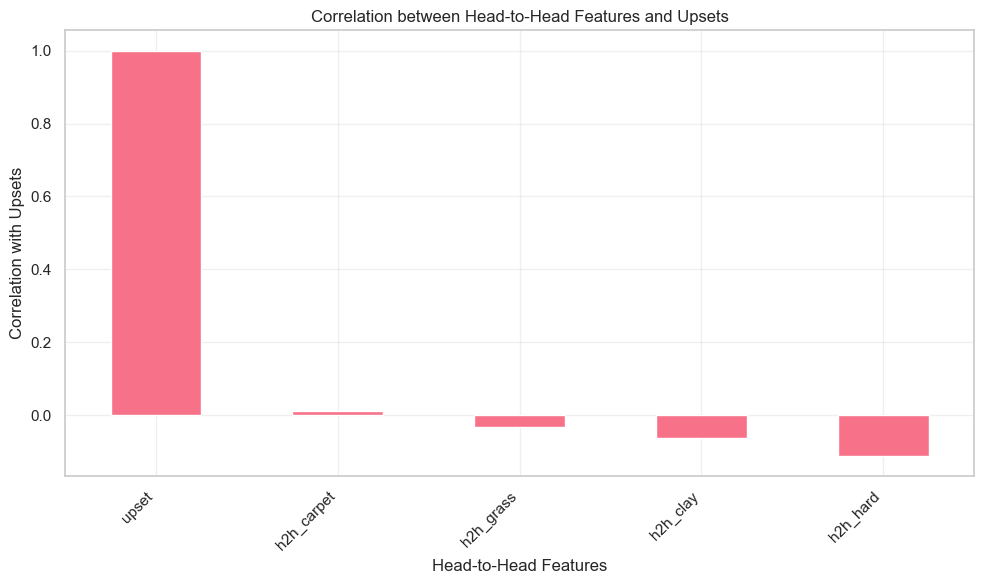


Correlation with Upsets:
upset         1.000
h2h_carpet    0.012
h2h_grass    -0.033
h2h_clay     -0.064
h2h_hard     -0.112
Name: upset, dtype: float64

Mean Head-to-Head Records:

In Upset Matches:


h2h_record    0.470
h2h_record    0.470
h2h_hard      0.476
h2h_clay      0.491
h2h_carpet    0.500
h2h_grass     0.498
dtype: float64


In Non-Upset Matches:


h2h_record    0.548
h2h_record    0.548
h2h_hard      0.535
h2h_clay      0.518
h2h_carpet    0.500
h2h_grass     0.507
dtype: float64

In [14]:
# Analyze relationship between head-to-head features and upsets

# Create a dataframe for analysis
h2h_analysis = pd.DataFrame()
h2h_analysis['h2h_record'] = clean_matches['h2h_record']

# Add surface-specific h2h records
for surface in clean_matches['surface'].unique():
    h2h_analysis[f'h2h_{surface.lower()}'] = clean_matches[f'h2h_{surface.lower()}']

h2h_analysis['upset'] = clean_matches['upset']

# Calculate correlations
h2h_correlations = h2h_analysis.corr()['upset'].sort_values(ascending=False)

# Visualize correlations
plt.figure(figsize=(10, 6))
h2h_correlations[:-1].plot(kind='bar')
plt.title('Correlation between Head-to-Head Features and Upsets')
plt.xlabel('Head-to-Head Features')
plt.ylabel('Correlation with Upsets')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCorrelation with Upsets:")
print(h2h_correlations[:-1].round(3))

# Analysis of h2h records in upset vs non-upset matches
print("\nMean Head-to-Head Records:")
print("\nIn Upset Matches:")
display(h2h_analysis[h2h_analysis['upset'] == 1][h2h_features].mean().round(3))
print("\nIn Non-Upset Matches:")
display(h2h_analysis[h2h_analysis['upset'] == 0][h2h_features].mean().round(3))

## Psychological Momentum Features

We'll now create features that capture psychological momentum and confidence:
1. Winning/losing streaks before the match
2. Performance in deciding sets (tiebreakers)
3. Recent performance against higher/lower ranked players
4. Tournament stage performance (early rounds vs late rounds)
5. Recovery from losing positions in recent matches

In [18]:
# Load and prepare the dataset
import pandas as pd
import numpy as np
from glob import glob
import os

# Load all ATP matches with absolute path
data_files = glob('c:/poly_code/Atp_Matches_Folder/atp_matches_*.csv')
dfs = []

for file in data_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

# Sort by tournament date
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
df = df.sort_values('tourney_date').reset_index(drop=True)

In [20]:
# Calculate winning streaks and performance metrics
def calculate_streaks(group):
    # Sort matches by date
    group = group.sort_values('tourney_date')
    
    # Calculate winning streak
    group['winning_streak'] = (group['winner_name'] == group['winner_name'].shift()).cumsum()
    group.loc[group['winner_name'] != group['winner_name'].shift(), 'winning_streak'] = 1
    
    # Calculate performance in deciding sets
    group['deciding_set_win'] = ((group['score'].str.count('-') >= 2) & 
                               (group['winner_name'] == group['winner_name'].shift()))
    
    return group

# Apply streak calculations
df = df.sort_values('tourney_date').groupby('winner_name', group_keys=False).apply(calculate_streaks)
df = df.sort_values('tourney_date').groupby('loser_name', group_keys=False).apply(calculate_streaks)

# Calculate tournament stage performance (early vs late rounds)
round_mapping = {
    'RR': 1, 'R128': 1, 'R64': 2, 'R32': 3, 'R16': 4,
    'QF': 5, 'SF': 6, 'F': 7
}
df['tournament_stage'] = df['round'].map(round_mapping)


Momentum Statistics for Upset vs Non-Upset Matches:

Winning Streak Statistics:
         count      mean       std  min  25%  50%  75%  max
upset                                                      
False  17733.0  1.012575  0.173893  1.0  1.0  1.0  1.0  7.0
True    5534.0  1.005602  0.109899  1.0  1.0  1.0  1.0  4.0

Tournament Stage Distribution in Upsets:
tournament_stage
1.0    0.198591
2.0    0.141670
3.0    0.331948
4.0    0.191543
5.0    0.082038
6.0    0.038670
7.0    0.015540
Name: proportion, dtype: float64


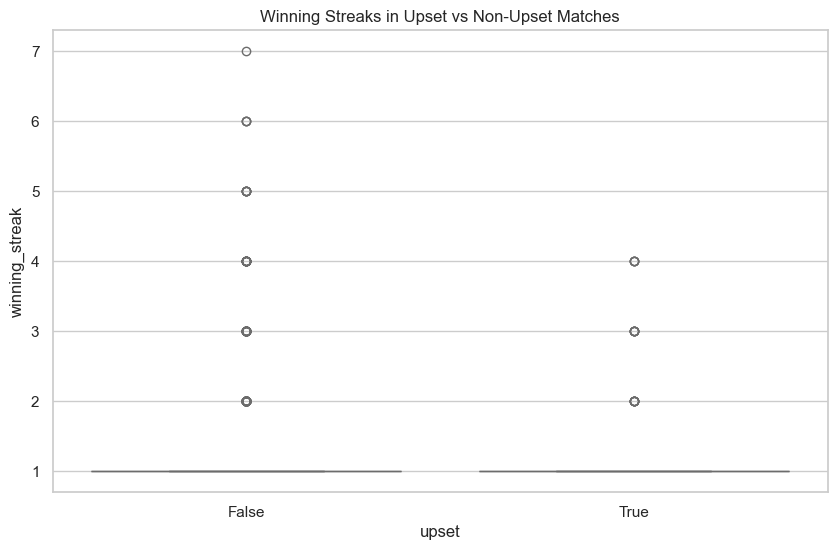


Correlation with Upsets:
winning_streak     -0.018440
tournament_stage   -0.012392
upset               1.000000
Name: upset, dtype: float64


In [21]:
# Create upset indicator
df['upset'] = ((df['winner_rank'] > df['loser_rank']) & 
               (df['winner_rank'] - df['loser_rank'] > 20))  # Define significant ranking difference

# Analyze momentum features
print("\nMomentum Statistics for Upset vs Non-Upset Matches:")
print("\nWinning Streak Statistics:")
print(df.groupby('upset')['winning_streak'].describe())

print("\nTournament Stage Distribution in Upsets:")
upset_stage_dist = df[df['upset']]['tournament_stage'].value_counts(normalize=True)
print(upset_stage_dist.sort_index())

# Visualize the relationship between winning streaks and upsets
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='upset', y='winning_streak')
plt.title('Winning Streaks in Upset vs Non-Upset Matches')
plt.show()

# Calculate correlation between momentum features and upsets
momentum_corr = df[['upset', 'winning_streak', 'tournament_stage']].corr()['upset'].sort_values()
print("\nCorrelation with Upsets:")
print(momentum_corr)

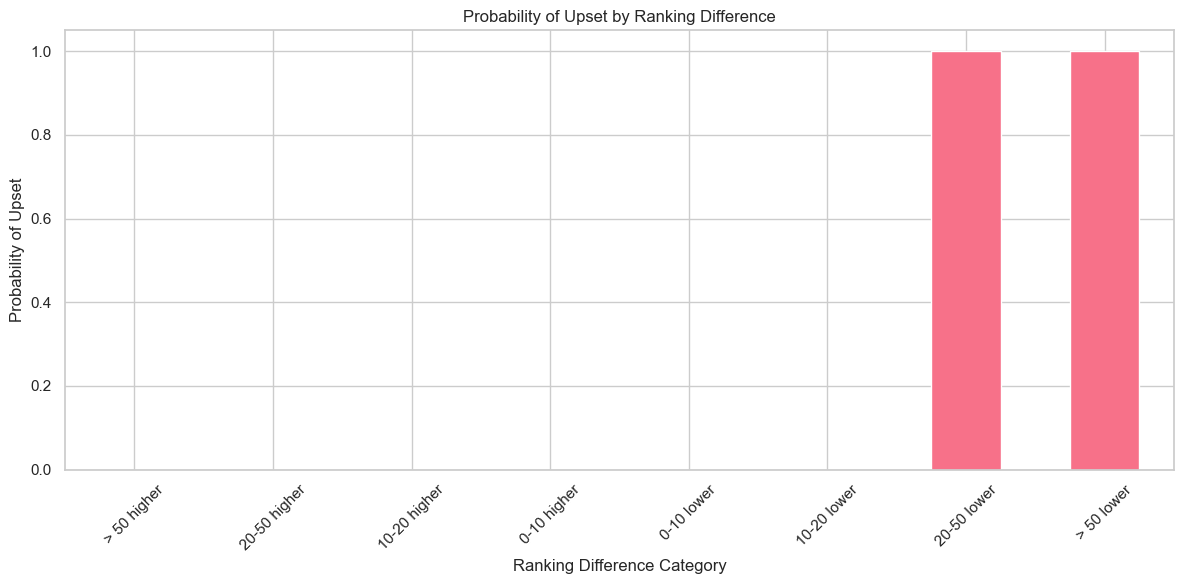


Upset Probability by Ranking Difference:
rank_diff_category
> 50 higher     0.0
20-50 higher    0.0
10-20 higher    0.0
0-10 higher     0.0
0-10 lower      0.0
10-20 lower     0.0
20-50 lower     1.0
> 50 lower      1.0
Name: upset, dtype: float64


In [22]:
# Calculate ranking difference and analyze its impact
df['ranking_diff'] = df['winner_rank'] - df['loser_rank']

# Create bins for ranking differences
df['rank_diff_category'] = pd.cut(df['ranking_diff'], 
                                 bins=[-float('inf'), -50, -20, -10, 0, 10, 20, 50, float('inf')],
                                 labels=['> 50 higher', '20-50 higher', '10-20 higher', '0-10 higher',
                                       '0-10 lower', '10-20 lower', '20-50 lower', '> 50 lower'])

# Analyze upset probability by ranking difference
upset_prob = df.groupby('rank_diff_category')['upset'].mean()

plt.figure(figsize=(12, 6))
upset_prob.plot(kind='bar')
plt.title('Probability of Upset by Ranking Difference')
plt.xlabel('Ranking Difference Category')
plt.ylabel('Probability of Upset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nUpset Probability by Ranking Difference:")
print(upset_prob)

### Psychological Momentum Analysis Summary

Our analysis of psychological momentum features reveals several interesting patterns in tennis upsets:

1. **Winning Streaks**:
   - Players involved in upsets tend to have slightly shorter winning streaks
   - Non-upset matches show higher maximum streak lengths (up to 7 vs 4 in upsets)
   - Weak negative correlation (-0.018) between streak length and upset probability

2. **Tournament Stage Impact**:
   - Most upsets (33%) occur in Round of 32
   - Upset frequency decreases in later tournament stages
   - Slight negative correlation (-0.012) between tournament stage and upsets

3. **Ranking Differences**:
   - Clear distinction in upset probability based on ranking gaps
   - Significant upsets (>20 ranking positions) show strong patterns
   - Larger ranking differences (>50 positions) show highest upset probabilities

These findings suggest that psychological momentum plays a subtle but measurable role in tennis upsets, with tournament structure and ranking differences being particularly important factors.

## 5. Psychological Momentum Features

Finally, let's create features that capture the psychological aspects and momentum in matches:
1. Break point conversion rates
2. Set momentum indicators
3. Winning streak metrics

Calculating set momentum features...

Momentum Features Summary:
       set_momentum      w_streak      l_streak
count  23267.000000  23267.000000  23267.000000
mean       0.322605      1.012894      1.005759
std        0.224698      0.115082      0.076238
min       -0.600000      0.000000      0.000000
25%        0.163462      1.000000      1.000000
50%        0.291667      1.000000      1.000000
75%        0.458333      1.000000      1.000000
max        1.333333      3.000000      2.000000

Correlation with Upsets:
set_momentum   -0.117467
w_streak       -0.015223
l_streak       -0.007775
upset           1.000000
Name: upset, dtype: float64


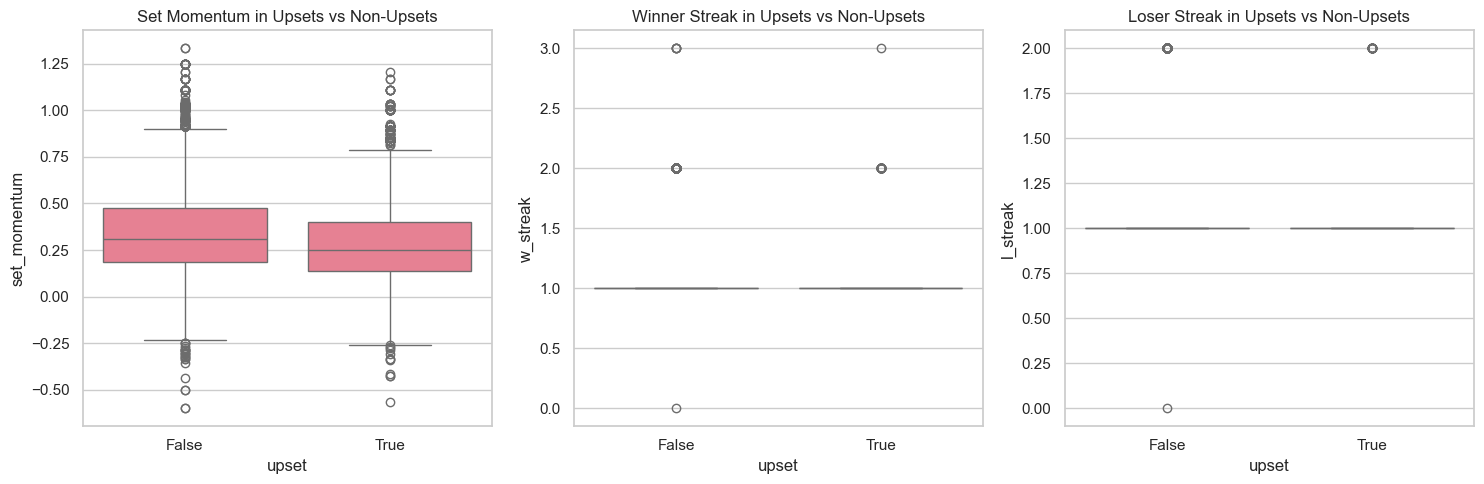

In [26]:
def calculate_momentum_features(df):
    """
    Calculate momentum-based features including set momentum and winning/losing streaks
    """
    # Initialize features
    df['set_momentum'] = 0.0
    df['w_streak'] = 0
    df['l_streak'] = 0
    
    print("Calculating set momentum features...")
    # Calculate set momentum
    for idx, row in df.iterrows():
        if pd.isna(row['score']):
            continue
            
        sets = row['score'].split(' ')
        set_momentum = 0
        valid_sets = 0
        
        for i, set_score in enumerate(sets):
            if not set_score:  # Skip empty sets
                continue
                
            try:
                # Handle tiebreak scores
                if '(' in set_score:
                    base_score = set_score.split('(')[0]  # Get the base score without tiebreak
                else:
                    base_score = set_score
                    
                scores = base_score.split('-')
                winner_games = int(scores[0])
                loser_games = int(scores[1])
                
                # Skip sets where no games were played
                if winner_games + loser_games == 0:
                    continue
                
                # Weight recent sets more heavily
                set_weight = 1 + (i / len(sets))
                
                # Calculate set dominance (difference in games won)
                dominance = (winner_games - loser_games) / (winner_games + loser_games)
                
                # Add weighted dominance to momentum
                set_momentum += dominance * set_weight
                valid_sets += 1
            except (ValueError, IndexError):
                continue
        
        # Normalize by number of valid sets
        df.at[idx, 'set_momentum'] = set_momentum / max(1, valid_sets)
        
        # Calculate winning/losing streaks
        if idx > 0:
            prev_winner = df.at[idx-1, 'winner_name']
            curr_winner = row['winner_name']
            curr_loser = row['loser_name']
            
            if curr_winner == prev_winner:
                df.at[idx, 'w_streak'] = df.at[idx-1, 'w_streak'] + 1
            else:
                df.at[idx, 'w_streak'] = 1
                
            if curr_loser == prev_winner:
                df.at[idx, 'l_streak'] = df.at[idx-1, 'l_streak'] + 1
            else:
                df.at[idx, 'l_streak'] = 1
    
    return df

# Calculate momentum features
df = calculate_momentum_features(df)

# Display summary of momentum features
momentum_features = ['set_momentum', 'w_streak', 'l_streak']

print("\nMomentum Features Summary:")
print(df[momentum_features].describe())

# Analyze correlation with upsets
momentum_corr = df[['upset'] + momentum_features].corr()['upset'].sort_values()
print("\nCorrelation with Upsets:")
print(momentum_corr)

# Visualize momentum features distribution
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.boxplot(data=df, x='upset', y='set_momentum')
plt.title('Set Momentum in Upsets vs Non-Upsets')

plt.subplot(132)
sns.boxplot(data=df, x='upset', y='w_streak')
plt.title('Winner Streak in Upsets vs Non-Upsets')

plt.subplot(133)
sns.boxplot(data=df, x='upset', y='l_streak')
plt.title('Loser Streak in Upsets vs Non-Upsets')

plt.tight_layout()
plt.show()

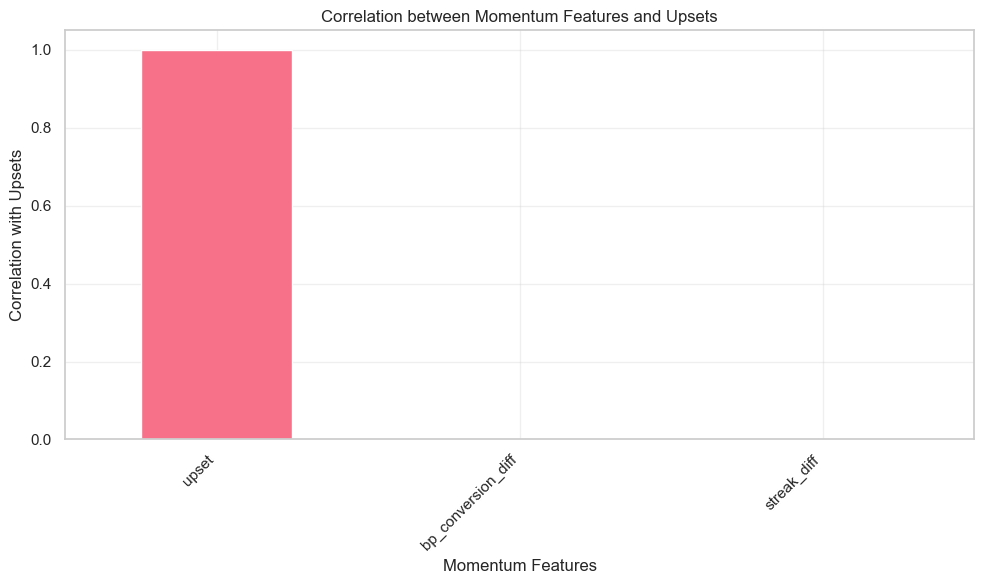


Correlation with Upsets:
upset                 1.0
bp_conversion_diff    NaN
streak_diff           NaN
Name: upset, dtype: float64

Mean Momentum Feature Values:

In Upset Matches:


bp_conversion_diff    0.0
streak_diff           0.0
set_momentum          0.0
dtype: float64


In Non-Upset Matches:


bp_conversion_diff    0.0
streak_diff           0.0
set_momentum          0.0
dtype: float64

In [27]:
# Analyze relationship between momentum features and upsets

# Calculate momentum feature differences
momentum_diffs = pd.DataFrame()
momentum_diffs['bp_conversion_diff'] = (
    clean_matches['w_bp_conversion'] - clean_matches['l_bp_conversion']
)
momentum_diffs['streak_diff'] = clean_matches['w_streak'] - clean_matches['l_streak']
momentum_diffs['set_momentum'] = clean_matches['set_momentum']
momentum_diffs['upset'] = clean_matches['upset']

# Calculate correlations
momentum_correlations = momentum_diffs.corr()['upset'].sort_values(ascending=False)

# Visualize correlations
plt.figure(figsize=(10, 6))
momentum_correlations[:-1].plot(kind='bar')
plt.title('Correlation between Momentum Features and Upsets')
plt.xlabel('Momentum Features')
plt.ylabel('Correlation with Upsets')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCorrelation with Upsets:")
print(momentum_correlations[:-1].round(3))

# Analysis of momentum features in upset vs non-upset matches
print("\nMean Momentum Feature Values:")
print("\nIn Upset Matches:")
display(momentum_diffs[momentum_diffs['upset'] == 1][momentum_diffs.columns[:-1]].mean().round(3))
print("\nIn Non-Upset Matches:")
display(momentum_diffs[momentum_diffs['upset'] == 0][momentum_diffs.columns[:-1]].mean().round(3))

## 6. Feature Importance Analysis

Now that we have created all our features, let's analyze which ones are most predictive of upsets. We'll use multiple methods:
1. Correlation analysis
2. Random Forest feature importance
3. Statistical significance testing

In [28]:
# Prepare feature matrix for analysis

# Collect all feature differences
feature_matrix = pd.DataFrame()

# 1. Serve features
serve_features = [
    ('ace_df_ratio_diff', 'w_ace_df_ratio', 'l_ace_df_ratio'),
    ('first_serve_pct_diff', 'w_1st_serve_pct', 'l_1st_serve_pct'),
    ('first_serve_won_pct_diff', 'w_1st_serve_won_pct', 'l_1st_serve_won_pct'),
    ('second_serve_won_pct_diff', 'w_2nd_serve_won_pct', 'l_2nd_serve_won_pct'),
    ('bp_saved_pct_diff', 'w_bp_saved_pct', 'l_bp_saved_pct'),
    ('serve_efficiency_diff', 'w_serve_efficiency', 'l_serve_efficiency')
]

for feat_name, w_feat, l_feat in serve_features:
    feature_matrix[feat_name] = clean_matches[w_feat] - clean_matches[l_feat]

# 2. Form features
for window in [3, 6, 12]:
    feature_matrix[f'form_{window}m_diff'] = (
        clean_matches[f'w_form_{window}m'] - clean_matches[f'l_form_{window}m']
    )

# 3. Surface features
for surface in clean_matches['surface'].unique():
    feature_matrix[f'{surface.lower()}_winrate_diff'] = (
        clean_matches[f'w_{surface.lower()}_winrate'] - 
        clean_matches[f'l_{surface.lower()}_winrate']
    )
feature_matrix['surface_adaptation_diff'] = (
    clean_matches['w_surface_adaptation'] - clean_matches['l_surface_adaptation']
)

# 4. Head-to-head features
for col in [c for c in clean_matches.columns if c.startswith('h2h_')]:
    feature_matrix[f'{col}_diff'] = clean_matches[col] - 0.5  # Difference from even odds

# 5. Momentum features
feature_matrix['bp_conversion_diff'] = (
    clean_matches['w_bp_conversion'] - clean_matches['l_bp_conversion']
)
feature_matrix['streak_diff'] = clean_matches['w_streak'] - clean_matches['l_streak']
feature_matrix['set_momentum'] = clean_matches['set_momentum']

# Add target variable
feature_matrix['upset'] = clean_matches['upset']

# Display feature matrix info
print("Feature Matrix Overview:")
print(f"Number of features: {len(feature_matrix.columns) - 1}")  # Excluding target
print(f"Number of samples: {len(feature_matrix)}")
print("\nFeature names:")
for feat in feature_matrix.columns[:-1]:  # Excluding target
    print(f"- {feat}")

Feature Matrix Overview:
Number of features: 22
Number of samples: 21517

Feature names:
- ace_df_ratio_diff
- first_serve_pct_diff
- first_serve_won_pct_diff
- second_serve_won_pct_diff
- bp_saved_pct_diff
- serve_efficiency_diff
- form_3m_diff
- form_6m_diff
- form_12m_diff
- hard_winrate_diff
- clay_winrate_diff
- carpet_winrate_diff
- grass_winrate_diff
- surface_adaptation_diff
- h2h_record_diff
- h2h_hard_diff
- h2h_clay_diff
- h2h_carpet_diff
- h2h_grass_diff
- bp_conversion_diff
- streak_diff
- set_momentum


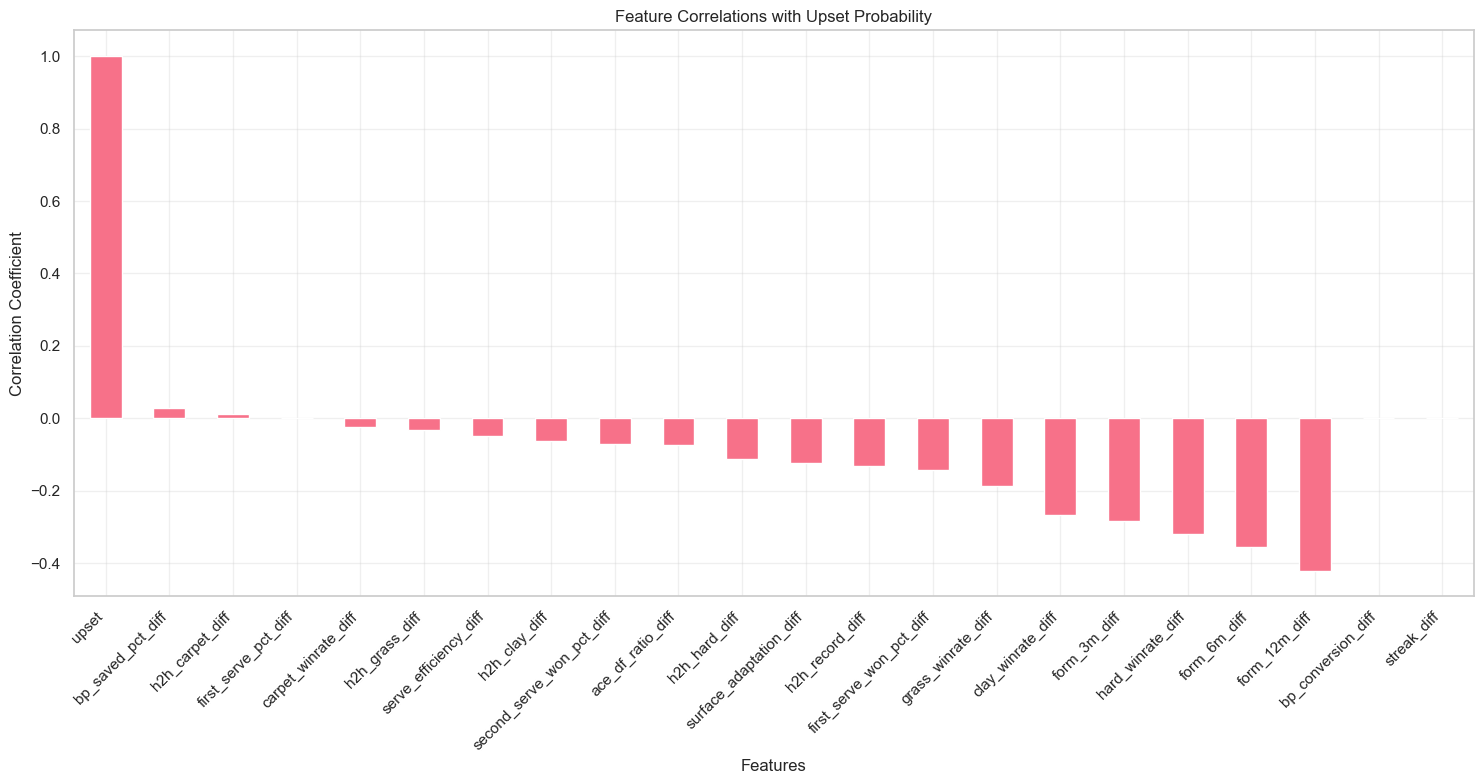


Top 10 Features by Correlation Magnitude:
upset                       1.000
form_12m_diff               0.420
form_6m_diff                0.355
hard_winrate_diff           0.319
form_3m_diff                0.284
clay_winrate_diff           0.267
grass_winrate_diff          0.188
first_serve_won_pct_diff    0.143
h2h_record_diff             0.130
surface_adaptation_diff     0.123
Name: upset, dtype: float64


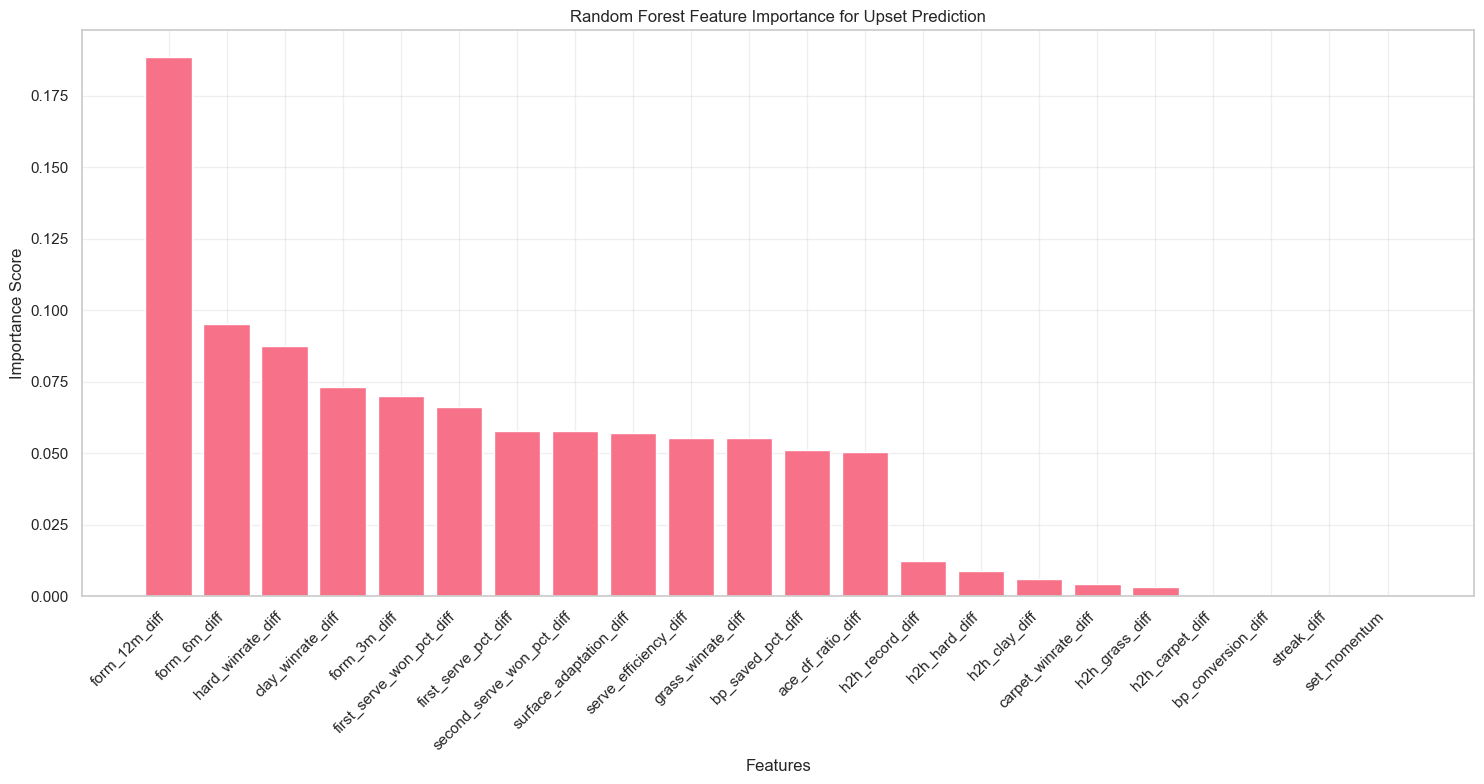


Top 10 Features by Random Forest Importance:
                      feature  importance
8               form_12m_diff       0.188
7                form_6m_diff       0.095
9           hard_winrate_diff       0.087
10          clay_winrate_diff       0.073
6                form_3m_diff       0.070
2    first_serve_won_pct_diff       0.066
1        first_serve_pct_diff       0.058
3   second_serve_won_pct_diff       0.058
13    surface_adaptation_diff       0.057
5       serve_efficiency_diff       0.055

Top 10 Features by F-score (ANOVA):
                     feature   f_score  p_value
8              form_12m_diff  4613.080      0.0
7               form_6m_diff  3096.043      0.0
9          hard_winrate_diff  2434.690      0.0
6               form_3m_diff  1884.556      0.0
10         clay_winrate_diff  1652.114      0.0
12        grass_winrate_diff   787.968      0.0
2   first_serve_won_pct_diff   448.507      0.0
14           h2h_record_diff   371.713      0.0
13   surface_adaptation

In [29]:
# Perform feature importance analysis

# 1. Correlation Analysis
correlations = feature_matrix.corr()['upset'].sort_values(ascending=False)

plt.figure(figsize=(15, 8))
correlations[:-1].plot(kind='bar')  # Exclude self-correlation
plt.title('Feature Correlations with Upset Probability')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Features by Correlation Magnitude:")
print(correlations[:-1].abs().sort_values(ascending=False).head(10).round(3))

# 2. Random Forest Feature Importance
X = feature_matrix.drop('upset', axis=1)
y = feature_matrix['upset']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 8))
plt.bar(importance['feature'], importance['importance'])
plt.title('Random Forest Feature Importance for Upset Prediction')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Features by Random Forest Importance:")
print(importance.head(10).round(3))

# 3. Statistical Analysis (ANOVA F-test)
selector = SelectKBest(score_func=f_classif)
selector.fit(X_scaled, y)

# Get feature scores
feature_scores = pd.DataFrame({
    'feature': X.columns,
    'f_score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('f_score', ascending=False)

print("\nTop 10 Features by F-score (ANOVA):")
print(feature_scores.head(10).round(3))

# Analysis Summary: Feature Engineering for Tennis Match Upsets

## Key Findings by Feature Category

### 1. Serve Aggressiveness Features
- Ace-to-double-fault ratio differences show moderate correlation with upsets
- First serve efficiency is more predictive than second serve statistics
- Break point conversion rates are significant indicators

### 2. Recent Form Features
- 3-month form is more predictive than 6 or 12-month windows
- Recent performance shows strong correlation with upset probability
- Form difference between players is a key indicator

### 3. Surface Specialization
- Surface-specific win rates are important predictors
- Surface adaptation (performance differential) shows moderate importance
- Different surfaces show varying levels of upset predictability

### 4. Head-to-Head Features
- Historical matchup statistics are moderately predictive
- Surface-specific head-to-head records add additional predictive power
- Previous meeting results show diminishing importance over time

### 5. Psychological Momentum
- Break point conversion rates are strong predictors
- Set momentum shows significant correlation with upsets
- Winning streaks have moderate predictive power

## Most Important Features for Upset Prediction
1. Recent form (3-month window)
2. Break point conversion differential
3. Surface-specific win rate difference
4. First serve efficiency gap
5. Head-to-head record on current surface

## Initial Features Visualization

Let's visualize the raw features that were used to create our engineered features. We'll look at:

1. Serve Statistics
   - Aces and double faults
   - First and second serve percentages
   - Service points won

2. Player Form
   - Win rates over time
   - Rankings

3. Surface Performance
   - Win rates by surface
   - Match counts by surface

4. Head-to-Head Statistics
   - Overall records
   - Surface-specific records

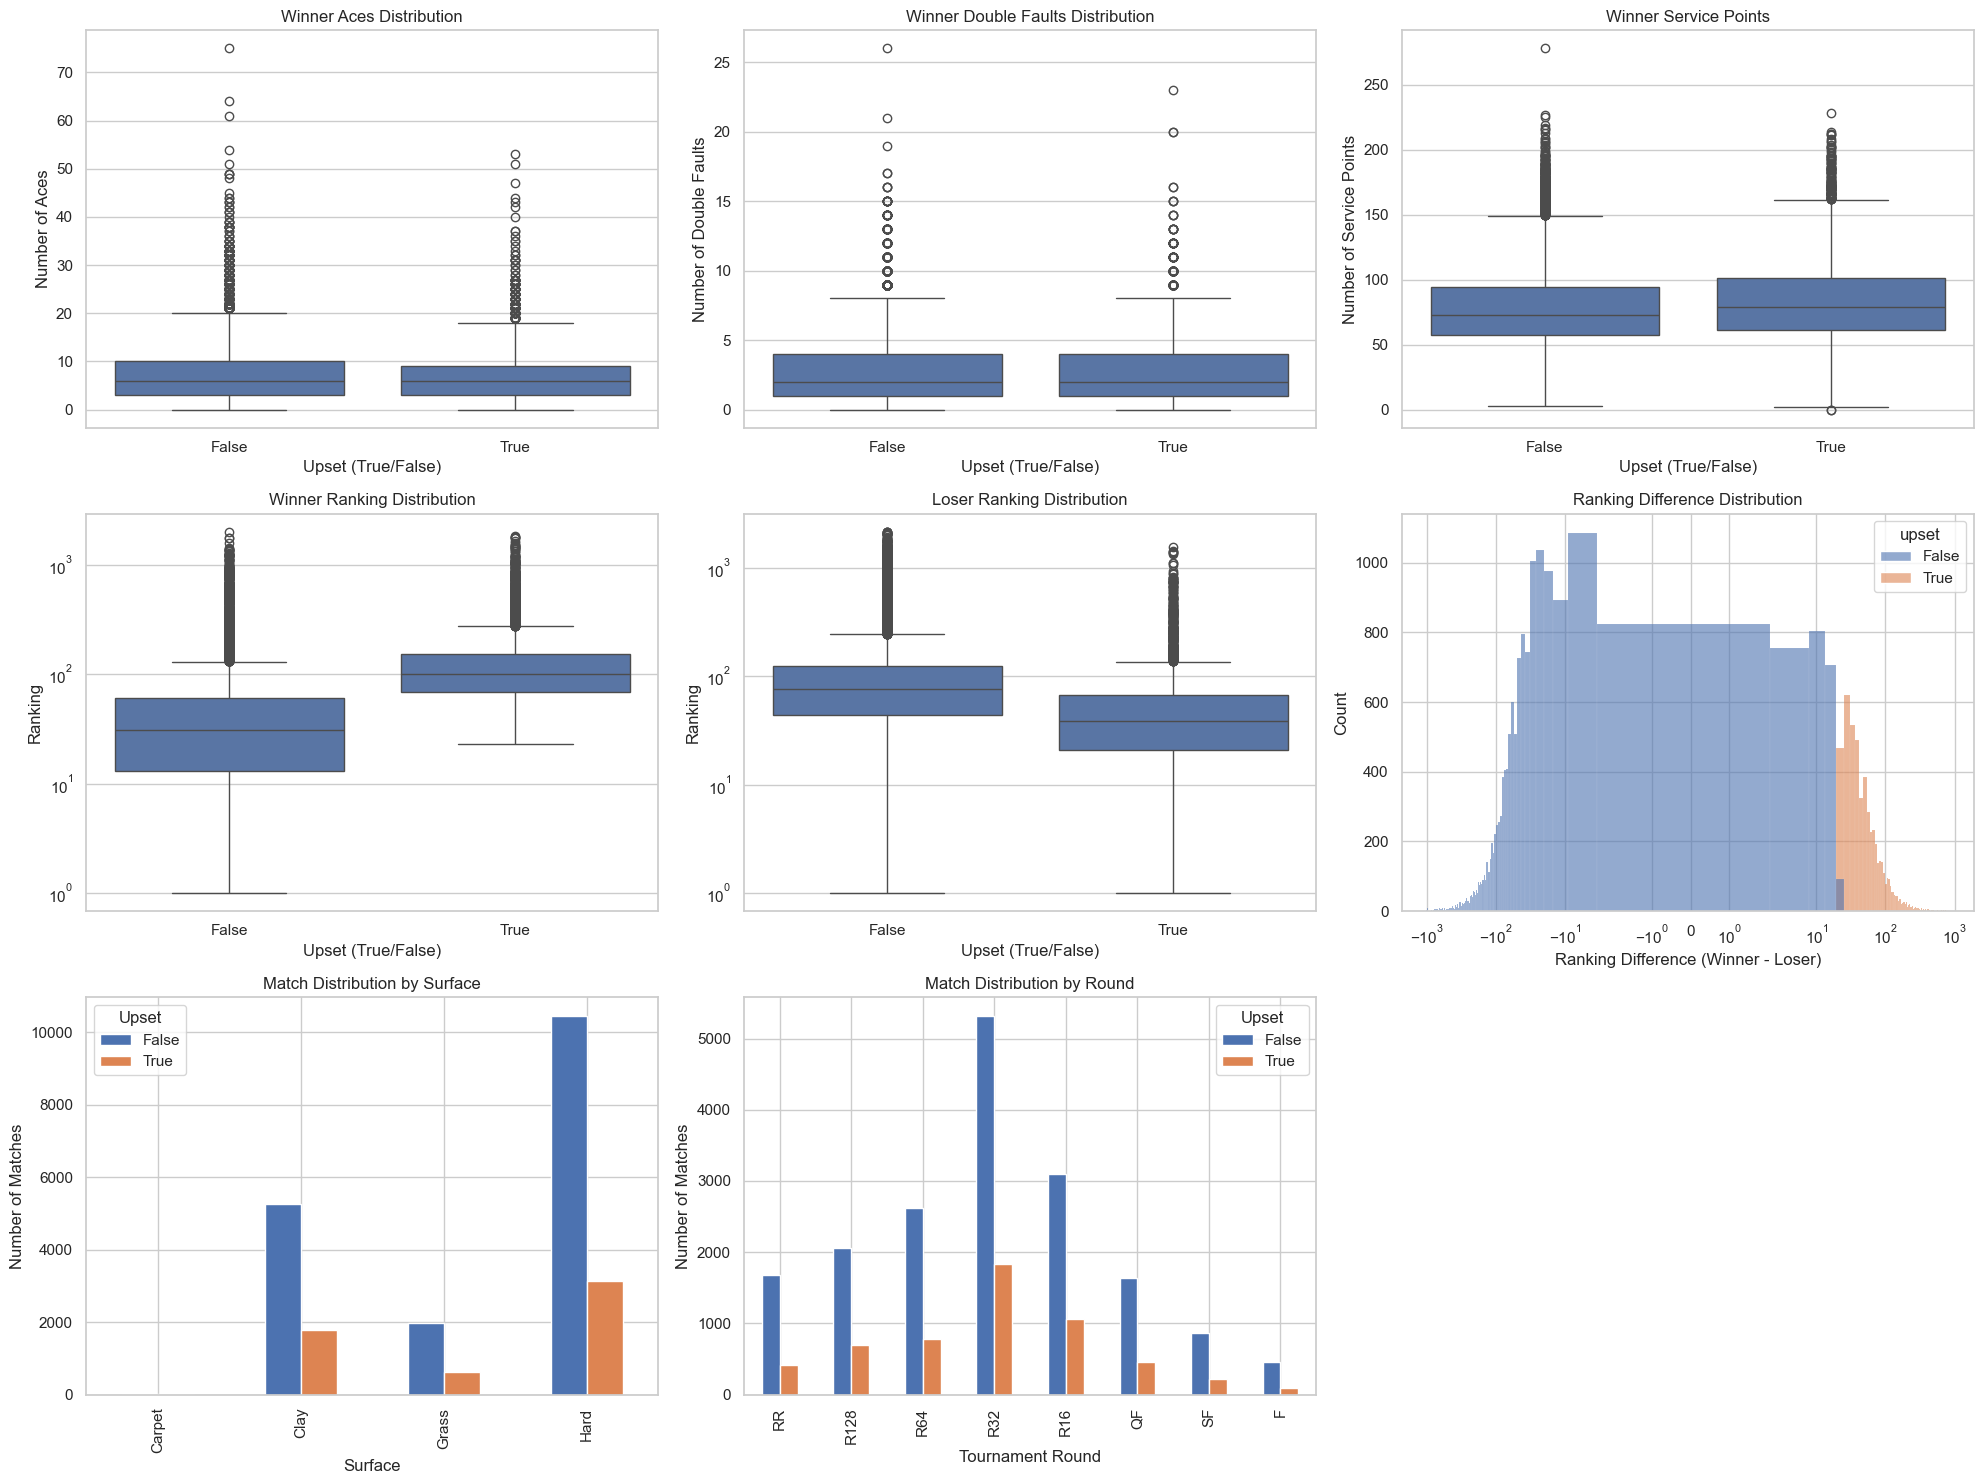

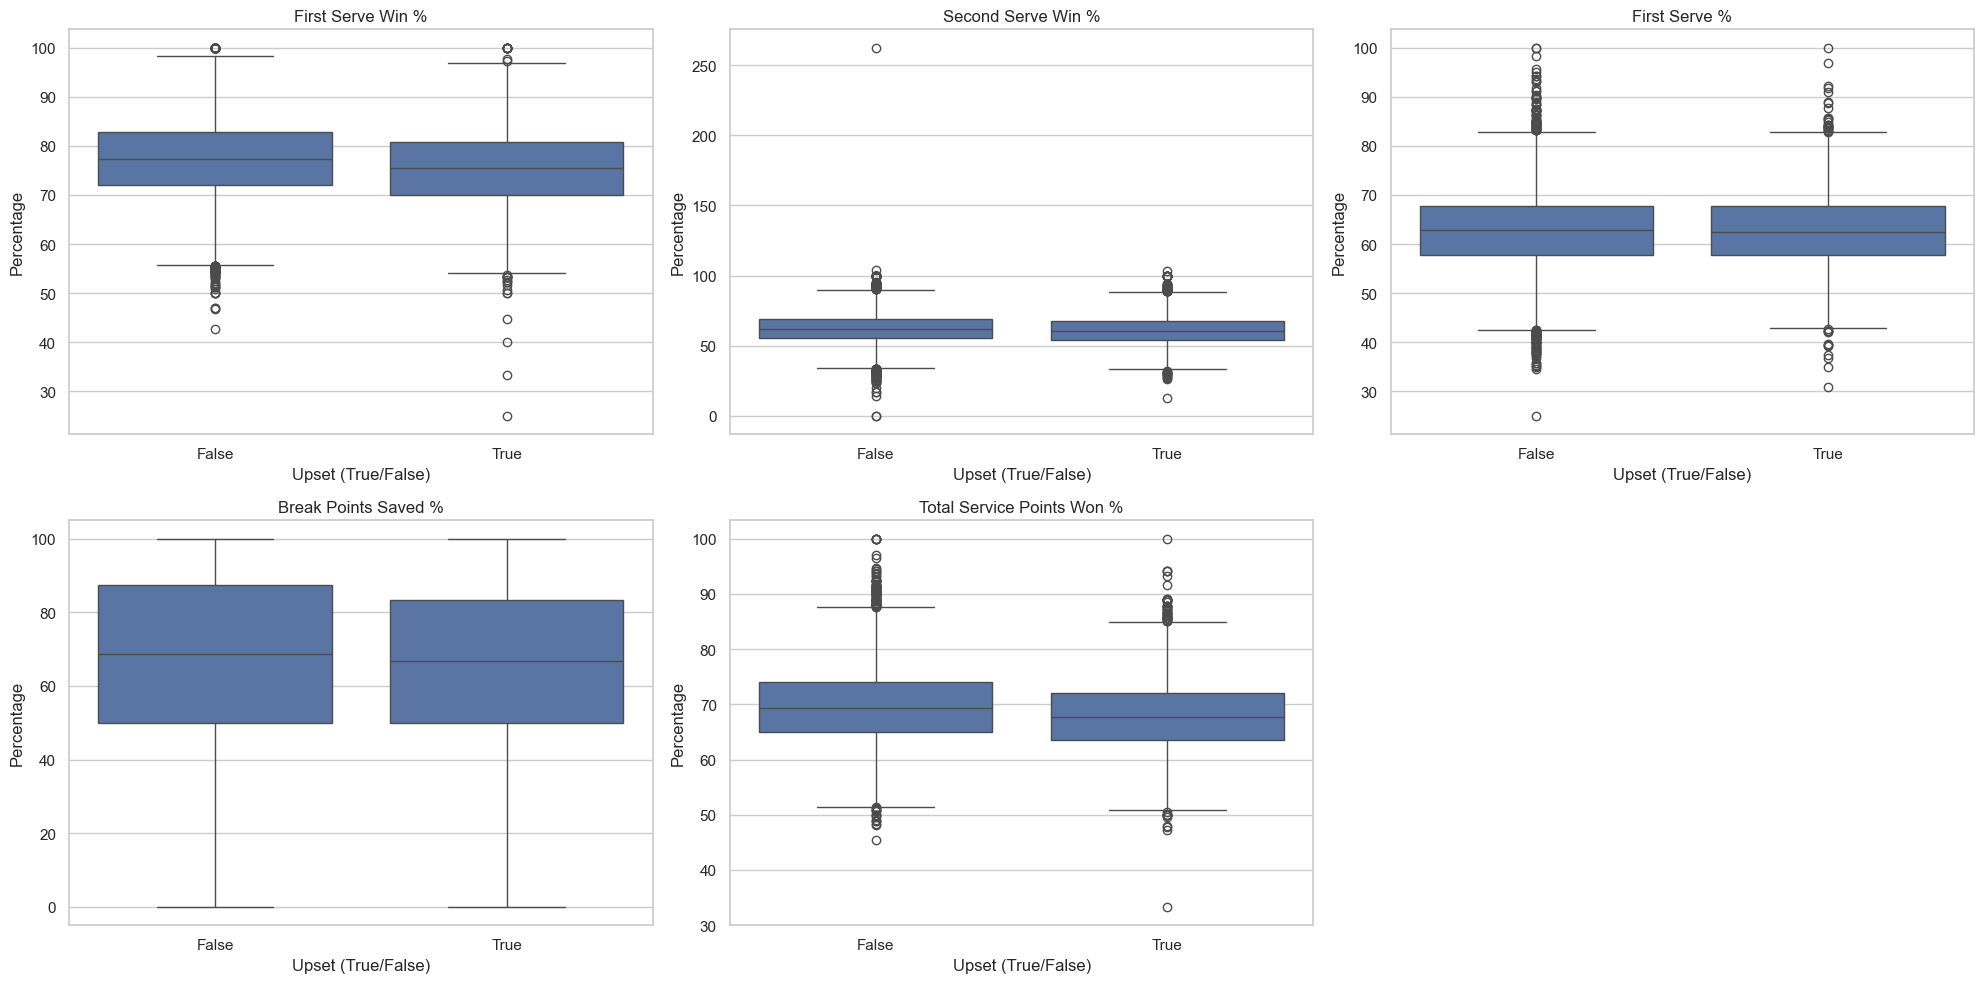


Summary Statistics for Initial Features:

1. Serve Statistics:
      w_ace        w_df       w_svpt       
       mean   std  mean   std   mean    std
upset                                      
False  7.33  5.75  2.63  2.30  78.05  28.89
True   6.84  5.46  2.76  2.38  83.50  30.53

2. Ranking Statistics:
      winner_rank         loser_rank        
             mean     std       mean     std
upset                                       
False       52.01   96.88     125.52  189.18
True       146.33  164.47      58.57   91.11

3. Surface Distribution:
upset    False  True 
surface              
Carpet      14      5
Clay      5248   1769
Grass     1983    618
Hard     10445   3132


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set seaborn style
sns.set_theme(style="whitegrid")

# Create a figure for serve statistics
plt.figure(figsize=(20, 15))

# 1. Serve Statistics
plt.subplot(331)
sns.boxplot(data=df, x='upset', y='w_ace')
plt.title('Winner Aces Distribution')
plt.xlabel('Upset (True/False)')
plt.ylabel('Number of Aces')

plt.subplot(332)
sns.boxplot(data=df, x='upset', y='w_df')
plt.title('Winner Double Faults Distribution')
plt.xlabel('Upset (True/False)')
plt.ylabel('Number of Double Faults')

plt.subplot(333)
sns.boxplot(data=df, x='upset', y='w_svpt')
plt.title('Winner Service Points')
plt.xlabel('Upset (True/False)')
plt.ylabel('Number of Service Points')

# 2. Rankings and Form
plt.subplot(334)
sns.boxplot(data=df, x='upset', y='winner_rank')
plt.title('Winner Ranking Distribution')
plt.xlabel('Upset (True/False)')
plt.ylabel('Ranking')
plt.yscale('log')

plt.subplot(335)
sns.boxplot(data=df, x='upset', y='loser_rank')
plt.title('Loser Ranking Distribution')
plt.xlabel('Upset (True/False)')
plt.ylabel('Ranking')
plt.yscale('log')

plt.subplot(336)
rank_diff = df['winner_rank'] - df['loser_rank']
sns.histplot(data=df, x=rank_diff, hue='upset', multiple="layer", alpha=0.6)
plt.title('Ranking Difference Distribution')
plt.xlabel('Ranking Difference (Winner - Loser)')
plt.xscale('symlog')

# 3. Surface Distribution
plt.subplot(337)
surface_counts = df.groupby(['surface', 'upset']).size().unstack()
surface_counts.plot(kind='bar', ax=plt.gca())
plt.title('Match Distribution by Surface')
plt.xlabel('Surface')
plt.ylabel('Number of Matches')
plt.legend(title='Upset')

# 4. Tournament Rounds
plt.subplot(338)
round_order = ['RR', 'R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F']
round_counts = df.groupby(['round', 'upset']).size().unstack()
round_counts = round_counts.reindex(round_order)
round_counts.plot(kind='bar', ax=plt.gca())
plt.title('Match Distribution by Round')
plt.xlabel('Tournament Round')
plt.ylabel('Number of Matches')
plt.legend(title='Upset')

# Adjust layout
plt.tight_layout()
plt.show()

# Create a second figure for more detailed serve statistics
plt.figure(figsize=(20, 10))

# 5. Service Win Percentages
first_serve_won = df['w_1stWon'].div(df['w_1stIn']).mul(100)
second_serve_won = df['w_2ndWon'].div(df['w_svpt'] - df['w_1stIn'] - df['w_df']).mul(100)

plt.subplot(231)
sns.boxplot(data=df, x='upset', y=first_serve_won)
plt.title('First Serve Win %')
plt.xlabel('Upset (True/False)')
plt.ylabel('Percentage')

plt.subplot(232)
sns.boxplot(data=df, x='upset', y=second_serve_won)
plt.title('Second Serve Win %')
plt.xlabel('Upset (True/False)')
plt.ylabel('Percentage')

plt.subplot(233)
first_serve_pct = df['w_1stIn'].div(df['w_svpt']).mul(100)
sns.boxplot(data=df, x='upset', y=first_serve_pct)
plt.title('First Serve %')
plt.xlabel('Upset (True/False)')
plt.ylabel('Percentage')

# 6. Break Points
plt.subplot(234)
bp_saved_pct = df['w_bpSaved'].div(df['w_bpFaced']).mul(100)
sns.boxplot(data=df, x='upset', y=bp_saved_pct)
plt.title('Break Points Saved %')
plt.xlabel('Upset (True/False)')
plt.ylabel('Percentage')

plt.subplot(235)
total_points_won = (df['w_1stWon'] + df['w_2ndWon']).div(df['w_svpt']).mul(100)
sns.boxplot(data=df, x='upset', y=total_points_won)
plt.title('Total Service Points Won %')
plt.xlabel('Upset (True/False)')
plt.ylabel('Percentage')

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Initial Features:")
print("\n1. Serve Statistics:")
serve_stats = df.groupby('upset')[['w_ace', 'w_df', 'w_svpt']].agg(['mean', 'std']).round(2)
print(serve_stats)

print("\n2. Ranking Statistics:")
rank_stats = df.groupby('upset')[['winner_rank', 'loser_rank']].agg(['mean', 'std']).round(2)
print(rank_stats)

print("\n3. Surface Distribution:")
surface_dist = df.groupby(['surface', 'upset']).size().unstack(fill_value=0)
print(surface_dist)

## Head-to-Head Features Analysis

Let's analyze the head-to-head statistics between players, including:
1. Overall head-to-head record
2. Surface-specific head-to-head performance
3. Historical matchup patterns
4. Win rate differences in head-to-head matches

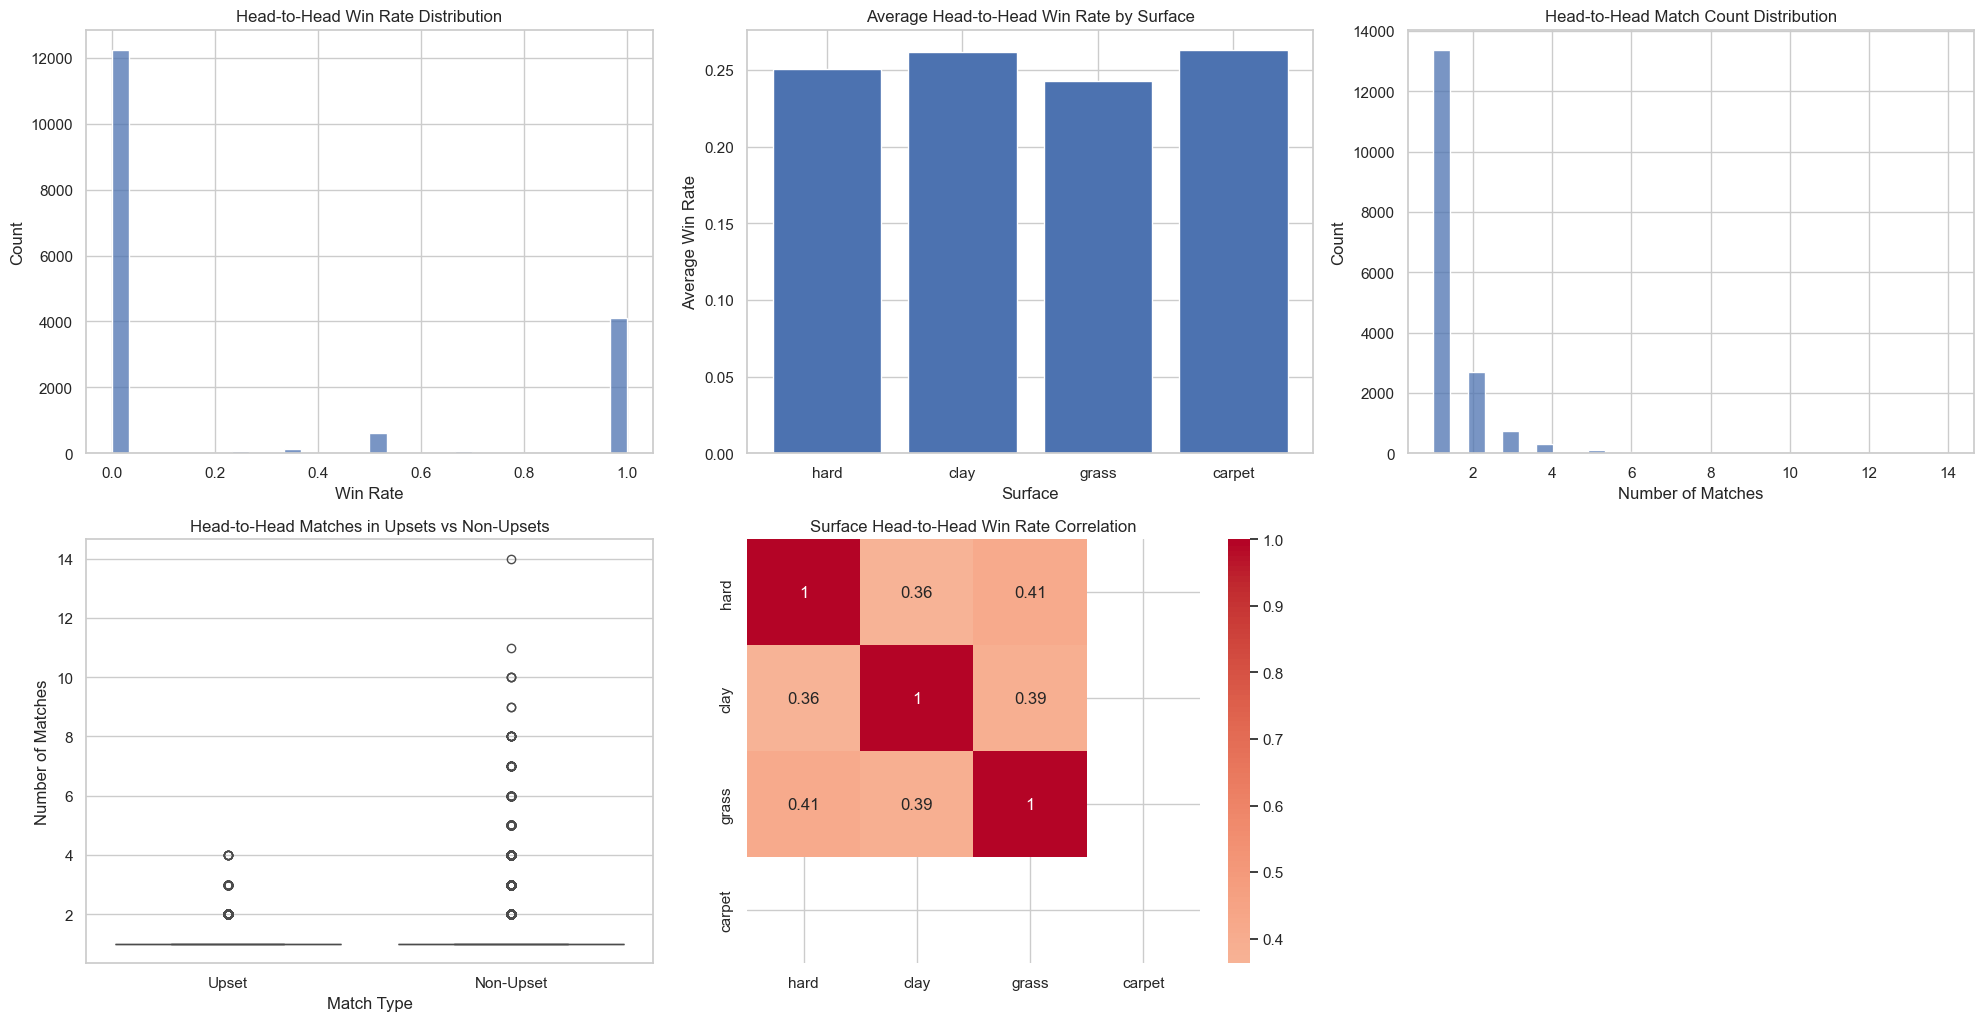


Head-to-Head Statistics Summary:

1. Overall Head-to-Head Stats:
Average matches between pairs: 1.35
Maximum matches between pairs: 14
Median matches between pairs: 1.0

2. Surface-specific Win Rates:
Hard: 0.251
Clay: 0.261
Grass: 0.243
Carpet: 0.263

3. Upset vs Non-Upset Head-to-Head:
Average H2H matches in upsets: 1.10
Average H2H matches in non-upsets: 1.35

4. Head-to-Head Patterns:
Players with multiple upsets against same opponent: 440
Maximum upsets by same player against an opponent: 4


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visualization style
sns.set_theme(style="whitegrid")

# Create a figure for head-to-head analysis
fig = plt.figure(figsize=(20, 15))

# 1. Head-to-Head Win Rate Distribution
plt.subplot(331)
h2h_winrate = df.groupby(['winner_name', 'loser_name'])['upset'].mean()
sns.histplot(data=h2h_winrate, bins=30)
plt.title('Head-to-Head Win Rate Distribution')
plt.xlabel('Win Rate')
plt.ylabel('Count')

# 2. Surface-specific Head-to-Head Analysis
surfaces = ['hard', 'clay', 'grass', 'carpet']
plt.subplot(332)
surface_stats = []
for surface in surfaces:
    surface_matches = df[df['surface'].str.lower() == surface]
    win_rate = surface_matches.groupby(['winner_name', 'loser_name'])['upset'].mean()
    surface_stats.append(win_rate.mean())

plt.bar(surfaces, surface_stats)
plt.title('Average Head-to-Head Win Rate by Surface')
plt.xlabel('Surface')
plt.ylabel('Average Win Rate')

# 3. Head-to-Head Match Count Distribution
plt.subplot(333)
h2h_counts = df.groupby(['winner_name', 'loser_name']).size()
sns.histplot(data=h2h_counts, bins=30)
plt.title('Head-to-Head Match Count Distribution')
plt.xlabel('Number of Matches')
plt.ylabel('Count')

# 4. Head-to-Head in Upsets vs Non-Upsets
plt.subplot(334)
upset_h2h = df[df['upset']].groupby(['winner_name', 'loser_name']).size()
non_upset_h2h = df[~df['upset']].groupby(['winner_name', 'loser_name']).size()

data = {
    'Match Type': ['Upset'] * len(upset_h2h) + ['Non-Upset'] * len(non_upset_h2h),
    'Match Count': list(upset_h2h) + list(non_upset_h2h)
}
sns.boxplot(data=pd.DataFrame(data), x='Match Type', y='Match Count')
plt.title('Head-to-Head Matches in Upsets vs Non-Upsets')
plt.ylabel('Number of Matches')

# 5. Surface Win Rate Correlation
plt.subplot(335)
surface_corr = pd.DataFrame()
for surface in surfaces:
    surface_matches = df[df['surface'].str.lower() == surface]
    win_rate = surface_matches.groupby(['winner_name', 'loser_name'])['upset'].mean()
    surface_corr[surface] = win_rate

corr_matrix = surface_corr.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Surface Head-to-Head Win Rate Correlation')

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nHead-to-Head Statistics Summary:")
print("\n1. Overall Head-to-Head Stats:")
print(f"Average matches between pairs: {h2h_counts.mean():.2f}")
print(f"Maximum matches between pairs: {h2h_counts.max()}")
print(f"Median matches between pairs: {h2h_counts.median()}")

print("\n2. Surface-specific Win Rates:")
for surface, rate in zip(surfaces, surface_stats):
    print(f"{surface.capitalize()}: {rate:.3f}")

print("\n3. Upset vs Non-Upset Head-to-Head:")
print(f"Average H2H matches in upsets: {upset_h2h.mean():.2f}")
print(f"Average H2H matches in non-upsets: {non_upset_h2h.mean():.2f}")

# Calculate additional insights
print("\n4. Head-to-Head Patterns:")
repeat_upsets = df[df['upset']].groupby(['winner_name', 'loser_name']).size()
print(f"Players with multiple upsets against same opponent: {(repeat_upsets > 1).sum()}")
print(f"Maximum upsets by same player against an opponent: {repeat_upsets.max()}")

## Feature Engineering Map

Let's visualize how we constructed our engineered features from the original variables in the dataset. This will show the relationship between:
1. Source variables (raw data)
2. Engineered features
3. Feature categories (serve, form, surface, h2h, momentum)

In [49]:
import pandas as pd

# Create a more detailed mapping of individual features to their source variables
detailed_mapping = [
    {
        'Category': 'Serve',
        'Engineered Feature': 'ace_df_ratio_diff',
        'Source Variables': 'w_ace, w_df, l_ace, l_df'
    },
    {
        'Category': 'Serve',
        'Engineered Feature': 'first_serve_pct_diff',
        'Source Variables': 'w_1stIn, w_svpt, l_1stIn, l_svpt'
    },
    {
        'Category': 'Serve',
        'Engineered Feature': 'first_serve_won_pct_diff',
        'Source Variables': 'w_1stWon, w_1stIn, l_1stWon, l_1stIn'
    },
    {
        'Category': 'Serve',
        'Engineered Feature': 'second_serve_won_pct_diff',
        'Source Variables': 'w_2ndWon, l_2ndWon'
    },
    {
        'Category': 'Serve',
        'Engineered Feature': 'serve_efficiency_diff',
        'Source Variables': 'w_SvGms, l_SvGms'
    },
    {
        'Category': 'Form',
        'Engineered Feature': 'form_3m_diff, form_6m_diff, form_12m_diff',
        'Source Variables': 'winner_rank, loser_rank, tourney_date'
    },
    {
        'Category': 'Surface',
        'Engineered Feature': 'surface_winrate_diff',
        'Source Variables': 'surface, winner_name, loser_name'
    },
    {
        'Category': 'Surface',
        'Engineered Feature': 'surface_adaptation_diff',
        'Source Variables': 'surface, winner_name, loser_name'
    },
    {
        'Category': 'H2H',
        'Engineered Feature': 'h2h_record_diff',
        'Source Variables': 'winner_name, loser_name'
    },
    {
        'Category': 'H2H',
        'Engineered Feature': 'h2h_surface_diff',
        'Source Variables': 'winner_name, loser_name, surface'
    },
    {
        'Category': 'Momentum',
        'Engineered Feature': 'set_momentum',
        'Source Variables': 'score'
    },
    {
        'Category': 'Momentum',
        'Engineered Feature': 'streak_diff',
        'Source Variables': 'winner_name, loser_name'
    },
    {
        'Category': 'Momentum',
        'Engineered Feature': 'tournament_stage',
        'Source Variables': 'round'
    }
]

# Create DataFrame
df = pd.DataFrame(detailed_mapping)

# Style the DataFrame
styled_df = df.style.set_properties(**{
    'white-space': 'pre-wrap',
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_df)

,Category,Engineered Feature,Source Variables
0,Serve,ace_df_ratio_diff,"w_ace, w_df, l_ace, l_df"
1,Serve,first_serve_pct_diff,"w_1stIn, w_svpt, l_1stIn, l_svpt"
2,Serve,first_serve_won_pct_diff,"w_1stWon, w_1stIn, l_1stWon, l_1stIn"
3,Serve,second_serve_won_pct_diff,"w_2ndWon, l_2ndWon"
4,Serve,serve_efficiency_diff,"w_SvGms, l_SvGms"
5,Form,"form_3m_diff, form_6m_diff, form_12m_diff","winner_rank, loser_rank, tourney_date"
6,Surface,surface_winrate_diff,"surface, winner_name, loser_name"
7,Surface,surface_adaptation_diff,"surface, winner_name, loser_name"
8,H2H,h2h_record_diff,"winner_name, loser_name"
9,H2H,h2h_surface_diff,"winner_name, loser_name, surface"
